In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import os
plt.style.use('ggplot')

# 1. Load Twitter sentiment dataset

In [19]:
data_dir = './data'
sentiment_df = pd.read_csv(os.path.join(data_dir, 'sentiment_data.csv'))

In [20]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df = sentiment_df.set_index(['date','symbol'])


In [21]:
sentiment_df['engagement_ratio'] = sentiment_df['twitterComments'] / sentiment_df['twitterLikes']

In [22]:
sentiment_df = sentiment_df[(sentiment_df['twitterLikes'] > 20) & (sentiment_df['twitterComments'] > 10)]

In [23]:
sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

# 2. Aggregate Monthly and calculate average sentiment for the month

In [24]:
aggregated_df = sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'),'symbol'])[['engagement_ratio']].mean()

In [25]:
aggregated_df['rank'] = aggregated_df.groupby(level=0)['engagement_ratio'].rank(ascending=False)

In [26]:
aggregated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

# 3. Select Top 5 Stock based on their cross-sectional ranking for each month

In [27]:
filtered_df = aggregated_df[
    (aggregated_df['rank'] <= 5) & 
    (~aggregated_df.index.get_level_values('symbol').isin(['MRO', 'ATVI']))
]

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(days=1)

In [28]:
filtered_df

,symbol,engagement_ratio,rank
date,,,
2021-12-01,AES,0.864613,2.0
2021-12-01,FCX,0.626323,5.0
2021-12-01,MNST,0.699721,3.0
2021-12-01,OXY,2.147741,1.0
2021-12-01,SLB,0.647374,4.0
...,...,...,...
2023-02-01,A,0.471572,5.0
2023-02-01,AES,0.533809,4.0
2023-02-01,BIIB,0.839303,1.0


In [29]:
filtered_df = filtered_df.reset_index().set_index(['date','symbol'])

In [30]:
filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           OXY             1.025579   3.0
2022-04-01 A               5.237230   1.0

# 4. Extract the stocks to form portfolios with at the start of each month

In [31]:
dates = filtered_df.index.get_level_values('date').unique().to_list()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.to_list()

fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

# 5. Download fresh stock prices for only selected/shortlisted stocks

In [32]:
stocks_list = [
    stock for stock in sentiment_df.index.get_level_values('symbol').unique().to_list()
    if stock not in ['ATVI', 'MRO']
]
print(stocks_list)

prices_df = yf.download(tickers=stocks_list,start='2021-01-01',end='2023-03-01',auto_adjust=False)

prices_df

[                       0%                       ]

['AAPL', 'AMD', 'AMZN', 'BA', 'CRM', 'ES', 'F', 'GOOG', 'GOOGL', 'JPM', 'META', 'MNST', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'PFE', 'TSLA', 'ABBV', 'ABT', 'C', 'CMG', 'DIS', 'EA', 'EBAY', 'FCX', 'GS', 'K', 'KEY', 'KO', 'MA', 'MO', 'MU', 'PEP', 'STZ', 'T', 'TSN', 'V', 'PG', 'OXY', 'AAL', 'DAL', 'EL', 'GILD', 'J', 'LUV', 'PM', 'SLB', 'AES', 'REGN', 'A', 'D', 'ILMN', 'L', 'CB', 'HBAN', 'BIIB', 'NUE', 'BKR', 'DD', 'TMO', 'AEP', 'ENPH', 'AAP', 'MRNA', 'INTC', 'LMT', 'NCLH', 'JNJ', 'PYPL', 'BMY', 'CVX', 'HON', 'XOM', 'DVN', 'MPC', 'RCL', 'AVGO', 'DG', 'DLTR', 'MDT', 'CCL', 'ALB']


[*********************100%***********************]  83 of 83 completed


Price        Adj Close                                                         \
Ticker               A    AAL         AAP        AAPL        ABBV         ABT   
Date                                                                            
2021-01-04  115.582764  15.13  143.031036  126.405212   88.933952  101.045952   
2021-01-05  116.527756  15.43  142.876511  127.968079   89.853600  102.296173   
2021-01-06  119.723236  15.52  151.130753  123.660492   89.077370  102.083183   
2021-01-07  122.908989  15.38  152.421585  127.880173   90.030762  103.074120   
2021-01-08  123.785767  15.13  154.594208  128.983932   90.503220  103.361191   
...                ...    ...         ...         ...         ...         ...   
2023-02-22  140.083130  15.56  137.374603  147.423279  139.722885   98.635498   
2023-02-23  141.187378  15.87  135.834610  147.908340  141.021164   98.501030   
2023-02-24  139.215454  15.56  132.812027  145.245239  141.614670   96.493538   
2023-02-27  140.181686  15.63  134.514618  146.443146  143.070618   95.830788   
2023-02-28  139.974670  15.98  138.656342  145.938248  142.718201   97.703796   

Price                                                    ...   Volume  \
Ticker            AEP        AES         ALB        AMD  ...      RCL   
Date                                                     ...            
2021-01-04  69.613190  20.197659  146.018738  92.300003  ...  5732800   
2021-01-05  69.519287  20.875547  155.872574  92.769997  ...  4029500   
2021-01-06  70.074203  21.709875  167.515427  90.330002  ...  3612500   
2021-01-07  68.204514  21.492599  176.029892  95.160004  ...  3993700   
2021-01-08  67.598396  22.092278  176.125595  94.580002  ...  3104200   
...               ...        ...         ...        ...  ...      ...   
2023-02-22  83.843124  23.392221  239.244171  76.610001  ...  2044600   
2023-02-23  83.741570  23.392221  246.427826  79.750000  ...  2066600   
2023-02-24  83.483086  23.327726  242.224442  78.089996  ...  2875100   
2023-02-27  83.150734  22.922350  249.505112  78.769997  ...  2459700   
2023-02-28  81.212067  22.738085  246.874374  78.580002  ...  3662300   

Price                                                                          \
Ticker         REGN       SLB      STZ         T      TMO       TSLA      TSN   
Date                                                                            
2021-01-04   911100   8743400  1202600  86700816  2220400  145914600  2177400   
2021-01-05   797700  16256600  1530200  83054520  2046700   96735600  2297100   
2021-01-06  1434700  19456300  1861700  73455520  2112300  134100000  1942200   
2021-01-07  1126600  14502400  2537100  71265359  2144400  154496700  2969400   
2021-01-08  1018800  11951900  1595400  72471656  2221700  225166500  2672400   
...             ...       ...      ...       ...      ...        ...      ...   
2023-02-22   415500   9181100  1092200  25308800  1705300  191828500  4217700   
2023-02-23   553300   6324500   979700  24845800  1160200  146360000  3403500   
2023-02-24   525900   8458700   702900  29138100   852600  142228100  2439300   
2023-02-27   557100   6287000   608200  22981100  1110600  161028300  3922200   
2023-02-28   622700  10634200  1136900  34154800  1188800  153144900  3556300   

Price                           
Ticker             V       XOM  
Date                            
2021-01-04  10318300  27764700  
2021-01-05   6869700  44035100  
2021-01-06   7206200  36484800  
2021-01-07  10967900  29528100  
2021-01-08   6513000  28628200  
...              ...       ...  
2023-02-22   4621800  13973800  
2023-02-23   5533800  11289400  
2023-02-24   4414400  14351000  
2023-02-27   4255300  11710500  
2023-02-28   5385400  18107000  

[542 rows x 498 columns]

# 6. Calculate Portfolio Returns with monly rebalancing

In [33]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna()

porfolio_df = pd.DataFrame()

for startdate in fixed_dates.keys():
    end_date = (pd.to_datetime(startdate) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')

    cols = fixed_dates[startdate]

    temp_df =  returns_df[startdate:end_date][cols].mean(axis=1).to_frame('portfolio_return')

    porfolio_df = pd.concat([porfolio_df,temp_df], axis=0)


In [34]:
porfolio_df

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


# 7. Download NASDAQ/QQQ prices and calculate returns

In [38]:
qqq_df = yf.download(tickers='QQQ',start='2021-01-01',end='2023-03-01',auto_adjust=False)
# Compute log returns
qqq_ret = np.log(qqq_df[['Adj Close']]).diff()  # Keep it as a DataFrame
qqq_ret.columns = ['nasdaq_return']  # Rename column

# Drop NaN values (first row will be NaN after diff())
qqq_ret.dropna(inplace=True)

porfolio_df = porfolio_df.merge(qqq_ret, left_index=True, right_index=True)

porfolio_df

[*********************100%***********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017542
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


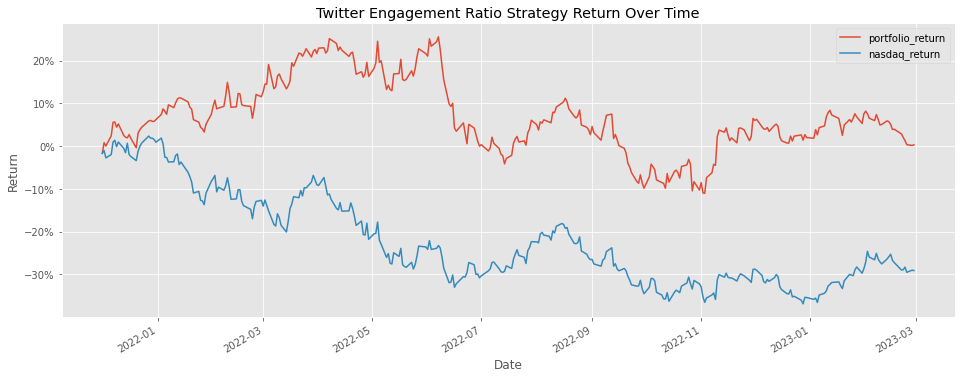

In [40]:
import matplotlib.ticker as mtick
portfolios_cumulative_return = np.exp(np.log1p(porfolio_df).cumsum()).sub(1)

# Plot the cumulative return
portfolios_cumulative_return.plot(figsize=(16, 6))

# Add title and labels
plt.title('Twitter Engagement Ratio Strategy Return Over Time')
plt.ylabel('Return')

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

# Show the plot
plt.show()